In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'PlantVillage'

In [ ]:
class_names = dataset.class_names
class_names

In [5]:
len(dataset) # the images are in batch, so if we do 32*68 = 2176 where we have 2152 images. so the extra slots for now assume it as 2176 is the total memory, BTW 1 batch = 32 images

364

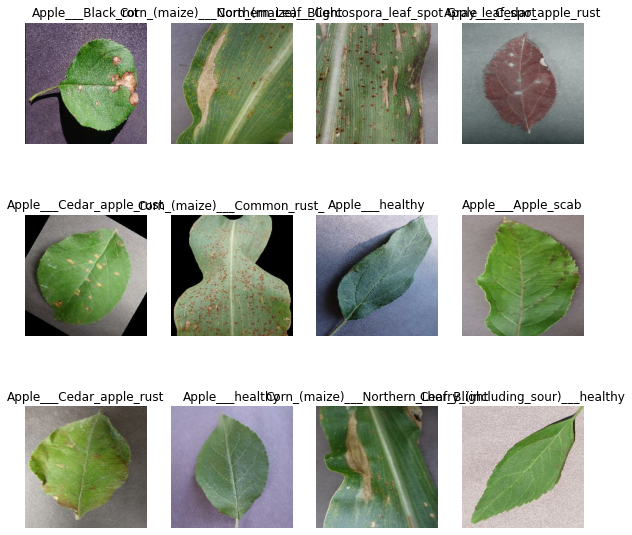

In [6]:
for image_batch, labels_batch in dataset.take(1):
    #print(image_batch.shape)
    #print(label_batch.numpy()) 
    
#the last 3 in the O/P is the RGB channel
#the 2nd set of number is from Out[6] where early blight is 0, late blight is 1 and healthy is 2

    #print(image_batch[0].numpy())                          #converting tensor into numpy
                                                            #print 1st image of the batch
    #print(image_batch[0].shape)                            #to get the shape of the image write print(image_batch[0].shape) instead of print(image_batch[0].numpy()) 
    plt.figure(figsize = (10,10))                           # to create some space between images
    for image_batch, labels_batch in dataset.take(1): 
        for i in range(12):                                     #to display 12 images of the batch
            ax = plt.subplot(3,4, i+1)                          #without this line it will show 1 img, so to show all the 12 images we are using the subplot and sort of create a table 
            plt.imshow(image_batch[i].numpy().astype("uint8"))  #to visualize the image, we are using matplotlib, so when we type "plt.imshow()" it expects a 3D array
                                                            #the .astype("uint8") is used because the image was in float instead of int thats why no data was shown
            
            plt.title(class_names[labels_batch[i]])              #to add name of the image we use label_batch[0] but this will show numbers, so we used class_names[label_batch[0]] to get the title of that class that the photo belongs
                                                            #.title is used to how the title of the img
            plt.axis("off")                                     # it is used to hide the x and y axis
    
    

In [7]:
train_size = 0.8
len(dataset)*train_size

291.2

In [8]:
train_ds = dataset.take(291)
len(train_ds)

291

In [9]:
test_ds = dataset.skip(291)
len(test_ds)

73

In [10]:
val_size = 0.1  #validation
len(dataset)*val_size

36.4

In [11]:
val_ds = test_ds.take(36)
len(val_ds)

36

In [12]:
test_ds = test_ds.skip(36)
len(test_ds)

37

In [13]:
#we just split our dataset into validation dataset and train dataset

In [14]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split +val_split ) == 1
    # this function takes the dataset and split ration that is 80% training , 10% validation and 10% test and shuffle it
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size) # train size in integer 
    val_size = int (val_split * ds_size) #validation size in integer
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)  # validation dataset
    test_ds = ds.skip(train_size).skip(val_size) # test dataset
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

291

In [17]:
len(val_ds)

36

In [18]:
len(test_ds)

37

In [19]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#prefetch() - when cpu is loading batch -2 the gpu willl load batch 1 at the same time


In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), # we need to resize the images
    layers.experimental.preprocessing.Rescaling(1.0/255),   # this will scale the image to 255
    
])
# this resize_and_rescale layer will go to the model and when we train our model and start predicting, during prediction when we supply an img which is not 256 by 256 i.e. different orientation, this will resize the img or us. 

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
#this data_augmentation layer will help to understand a rotated img

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE) #NEW

In [23]:
#CNN

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (64, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (64, 30, 30, 64)         

In [25]:
 # in deeplearing we define the neural network architecture first, then compile using optimizers like adam
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 verbose=1)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
    callbacks=[cp_callback],
)

os.listdir(checkpoint_dir)

Epoch 1/3
291/291 [==============================] - 638s 2s/step - loss: 1.0221 - accuracy: 0.6155 - val_loss: 1.2478 - val_accuracy: 0.6879

Epoch 00001: val_loss improved from inf to 1.24780, saving model to training_1\cp.ckpt
INFO:tensorflow:Assets written to: training_1\cp.ckpt\assets
Epoch 2/3
291/291 [==============================] - 598s 2s/step - loss: 0.3606 - accuracy: 0.8733 - val_loss: 0.5461 - val_accuracy: 0.8112

Epoch 00002: val_loss improved from 1.24780 to 0.54606, saving model to training_1\cp.ckpt
INFO:tensorflow:Assets written to: training_1\cp.ckpt\assets
Epoch 3/3
291/291 [==============================] - 586s 2s/step - loss: 0.2145 - accuracy: 0.9230 - val_loss: 0.2947 - val_accuracy: 0.8963

Epoch 00003: val_loss improved from 0.54606 to 0.29475, saving model to training_1\cp.ckpt
INFO:tensorflow:Assets written to: training_1\cp.ckpt\assets


['checkpoint', 'cp.ckpt', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [27]:
scores = model.evaluate(test_ds)

37/37 [==============================] - 60s 439ms/step - loss: 0.2887 - accuracy: 0.8978


In [28]:
scores

[0.28865379095077515, 0.8978040814399719]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 291}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

3

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0221365690231323, 0.3605562448501587, 0.21451233327388763]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

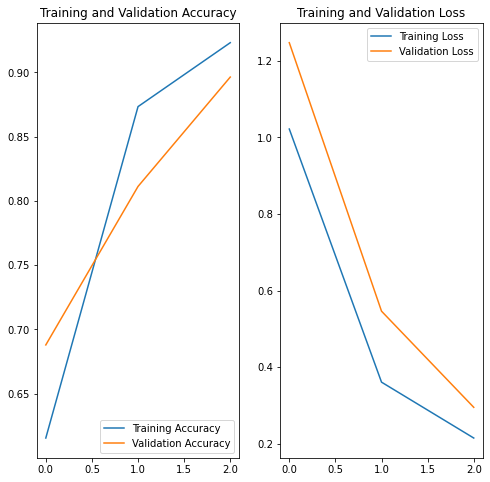

In [36]:
#plotting the traing and plotting accuracy

#accuracy chart
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#loss chart
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First image to predict
First image's actual label:  Cherry_(including_sour)___Powdery_mildew
Predicted Label:  Cherry_(including_sour)___Powdery_mildew


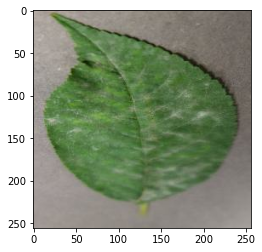

In [37]:
#make a prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    #print(images_batch[0].numpy().astype('uint8'))
    #print will show as 3D rgb formate
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])
    
    #lets do some prediction since model is complete
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

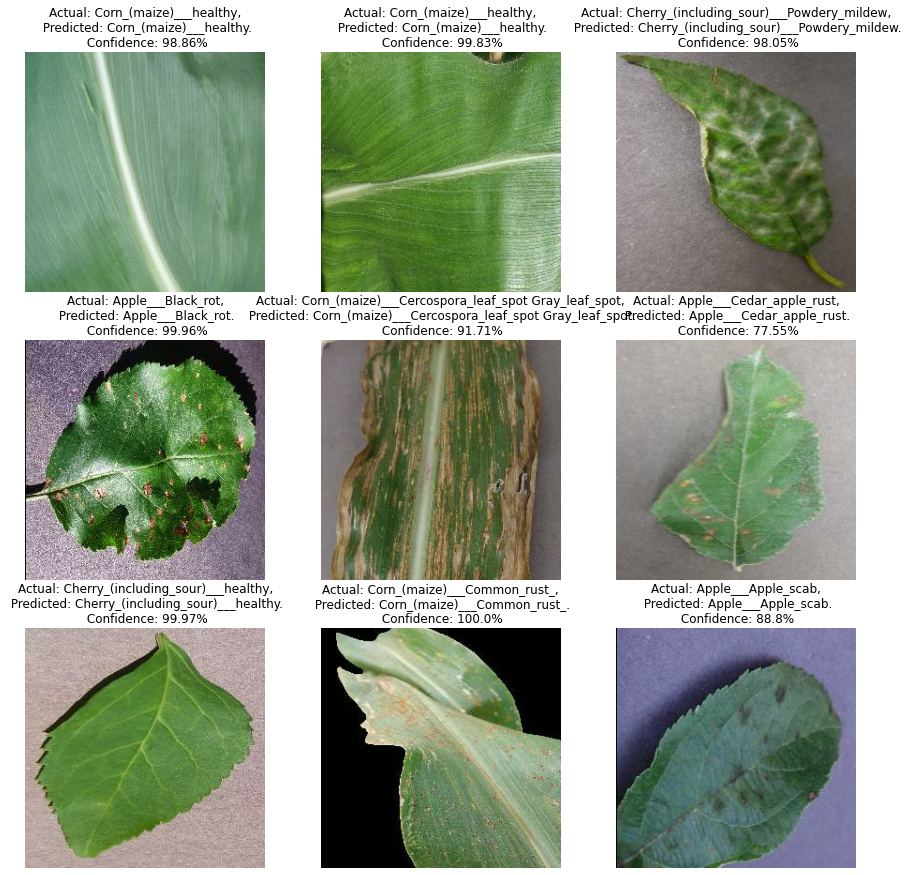

In [39]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import os
#model_version = 1
#model.save_weights(f"../models/{model_version}")
#model.save(f"../models/{model_version}")

#model_version=max([int(i) for i in os.listdir("E:/CSE 299/project299/cse299.5/models") + [0]])+1
#model.save("E:/CSE 299/project299/cse299.5/models/{model_version}")

# Setup base model and freeze its layers (this will extract features)

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [48]:
model.save("../three_epochs_trainingSet_1.h5")

In [42]:
#tfLite model
converter = tf.lite.TFLiteConverter.from_saved_model(f"../models/{model_version}")
tflite_model = converter.convert()

In [43]:
#tflite quantized model
converter = tf.lite.TFLiteConverter.from_saved_model(f"../models/{model_version}")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [44]:
len(tflite_model)

743320

In [45]:
len(tflite_quant_model)

203552

In [46]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [47]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)